In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
import pandas as pd
import numpy as np
import math
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter

float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size

In [2]:
import random  # for generating random ufuns

random.seed(0)  # for reproducibility
from pprint import pprint  # for printing
from negmas import ResponseType
from negmas import PreferencesChangeType
from negmas.sao import SAOMechanism, AspirationNegotiator, SAONegotiator
from negmas.outcomes import make_issue
from negmas.preferences import (
    MappingUtilityFunction,
    LinearAdditiveUtilityFunction as LUFun,
)
from negmas.preferences.value_fun import LinearFun, IdentityFun, AffineFun
from rich import print

## Develop a new negotiator
In this section, we go through the process of developing a new agent for the Stacked Alternating offers Protocols. Firstly, let's look at an example from the previous tutorial in which we simulate a buyer and a seller negotiating over a deal using time-based negotiators.

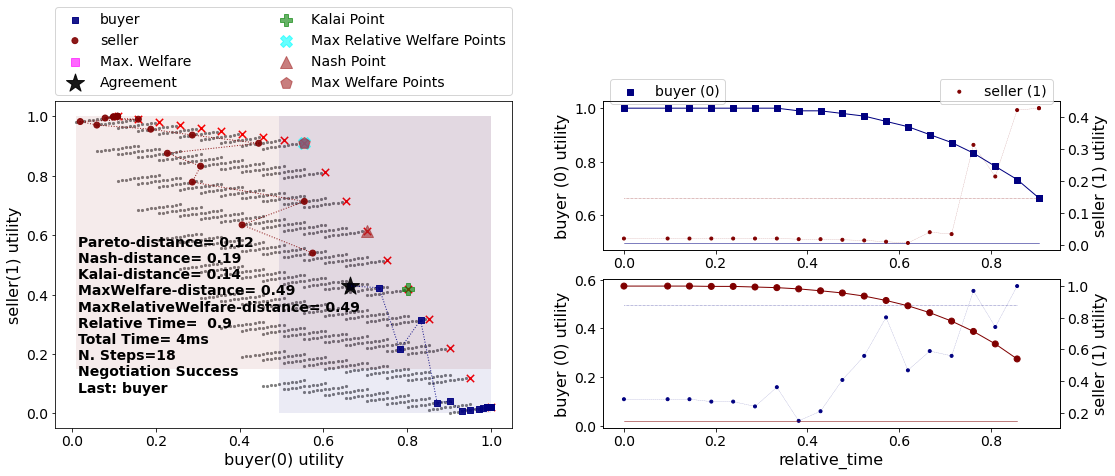

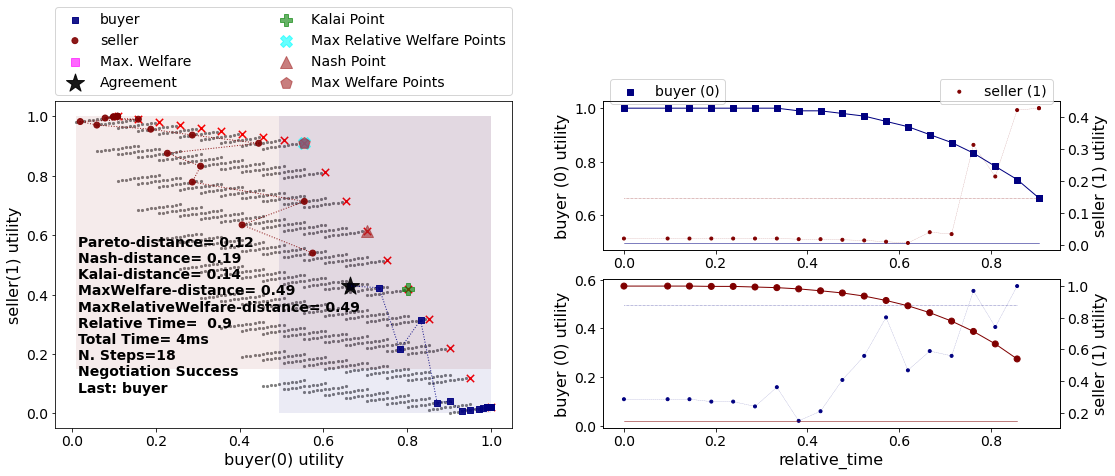

In [3]:
# create negotiation agenda (issues)
issues = [
    make_issue(name="price", values=10),
    make_issue(name="quantity", values=(1, 11)),
    make_issue(name="delivery_time", values=10),
]

# create the mechanism
session = SAOMechanism(issues=issues, n_steps=20)

# define ufuns
seller_utility = LUFun(
    values={
        "price": IdentityFun(),
        "quantity": LinearFun(0.2),
        "delivery_time": AffineFun(-1, bias=9),
    },
    weights={"price": 1.0, "quantity": 1.0, "delivery_time": 10.0},
    outcome_space=session.outcome_space,
    reserved_value=15,
).scale_max(1.0)
buyer_utility = LUFun(
    values={
        "price": AffineFun(-1, bias=9.0),
        "quantity": LinearFun(0.2),
        "delivery_time": IdentityFun(),
    },
    outcome_space=session.outcome_space,
    reserved_value=10,
).scale_max(1.0)

session.add(AspirationNegotiator(name="buyer"), ufun=buyer_utility)
session.add(AspirationNegotiator(name="seller"), ufun=seller_utility)
session.run()
session.plot()

The negotiation ended with an agreement far from the pareto-front (pareto-distance = $0.31$) which does not seem like a good result. What is the problem? 

Looking carefully at the 2D representation of the negotiation above, we can immediately see the issue: uninformed concession. Consider the buyer agent. It started with offering the best outcome for itself (The green offers above) and repeated it for a while (as expected) then started conceding (i.e. offering outcomes with lower utility for itself. Nevertheless, when it did conceed, it did not consider its partner at all. The figure below shows the same figure focusing on one specific choice the buyer did:
![Uninformed Concession](uninformed.png)

The problem is highlighted in orange. Even though the buyer had several offers that are *of the same utility for itself*, they are not of the same utility *to its partner*. In the figure, it is clear that the buyer, chose the offer that was in fact the *worst* for its opponent. Choosing any other offer in the orange rectangle could have been better as it is nearer to the pareto-front. By offering this way, the partners are *leaving money on the table*. 

Could the buyer have done better? Yes. By the time it gave this offer, it already have received several offers from the seller which could have been used to *estimate* the utility of different outcomes the buyer is cosidering offering for the seller (highlighted in red).

The ideas we want to implement is pretty simple:   
**Use a time-based consession strategy but always offer the outcome nearest to the first offer of the partner**


The intuition behind this simple strategy relies on two assumptions:

1. The partner's first offer is most likely its best outcome. Most negotiators will start with the best outcome for themselves.
2. Nearer outcomes in the outcome-space, are likely to have similar utilities (i.e. the utility function of the partner is smooth).

Both of these assumptions are sometimes violated but our goal here is to develop a *simple* yet useful negotiator not to end once and for all the hunt for the most effective negotiation strategy. With that said, let's dive in.

### Building a random negotiator

As a first step, we will build a negotiator that acts randomly.

Let's assume that we are too lazy to even read the documentation and want to learn how to develop a negotiator for the stacked alternating offers protocol. The first thing is to create a negotiator class and see what are the methods we need to override. All negotiators for the SAO mechanism should inherit from the `SAONegotiator` base class. Let's try to do that 

In [4]:
class RandomNegotiator(SAONegotiator):
    ...


try:
    RandomNegotiator()
except Exception as e:
    print(e)

Can't instantiate abstract class RandomNegotiator with abstract method propose

This is telling us that there is one (and only one) required abstract method that we need to override called `propose()`. This is the signature of this method:

```python
def proposed(self, state: SAOState) -> Outcome:
    ...
```

It receives the negotiation `state` which has all information available to the negotiator about the current state of the negotiation and generates an outcome to *offer* to the opponent. That is it. Moreover, we should know that the negotiator always have access to a `NegotiatorMechanismInterface` object that gives it unchanging information about the negotiation (for example the number of allowed rounds, any real-time limits on the negotiation, the number of partners, etc). This interface is accessible through the `nmi` member of the negotiator. With this knowledge,  we can build our first negotiator which will simply offer randomly. 

In [5]:
class RandomNegotiator(SAONegotiator):
    def propose(self, state):
        return self.nmi.random_outcomes(1)[0]

Let's define a helper function for testing our negotiator that replaces the buyer and/or seller negotiators in the code sample we used above:

In [6]:
def try_negotiator(cls, replace_buyer=True, replace_seller=True, plot=True, n_steps=20):
    buyer_cls = cls if replace_buyer else AspirationNegotiator
    seller_cls = cls if replace_seller else AspirationNegotiator

    # create negotiation agenda (issues)
    issues = [
        make_issue(name="price", values=10),
        make_issue(name="quantity", values=(1, 11)),
        make_issue(name="delivery_time", values=10),
    ]

    # create the mechanism
    session = SAOMechanism(issues=issues, n_steps=n_steps)

    # define ufuns
    seller_utility = LUFun(
        values={
            "price": IdentityFun(),
            "quantity": LinearFun(0.2),
            "delivery_time": AffineFun(-1, bias=9),
        },
        weights={"price": 1.0, "quantity": 1.0, "delivery_time": 10.0},
        outcome_space=session.outcome_space,
        reserved_value=15.0,
    ).scale_max(1.0)
    buyer_utility = LUFun(
        values={
            "price": AffineFun(-1, bias=9.0),
            "quantity": LinearFun(0.2),
            "delivery_time": IdentityFun(),
        },
        outcome_space=session.outcome_space,
        reserved_value=10.0,
    ).scale_max(1.0)

    session.add(buyer_cls(name="buyer"), ufun=buyer_utility)
    session.add(seller_cls(name="seller"), ufun=seller_utility)
    session.run()
    if plot:
        session.plot()
    return session

... and try our first attempt:

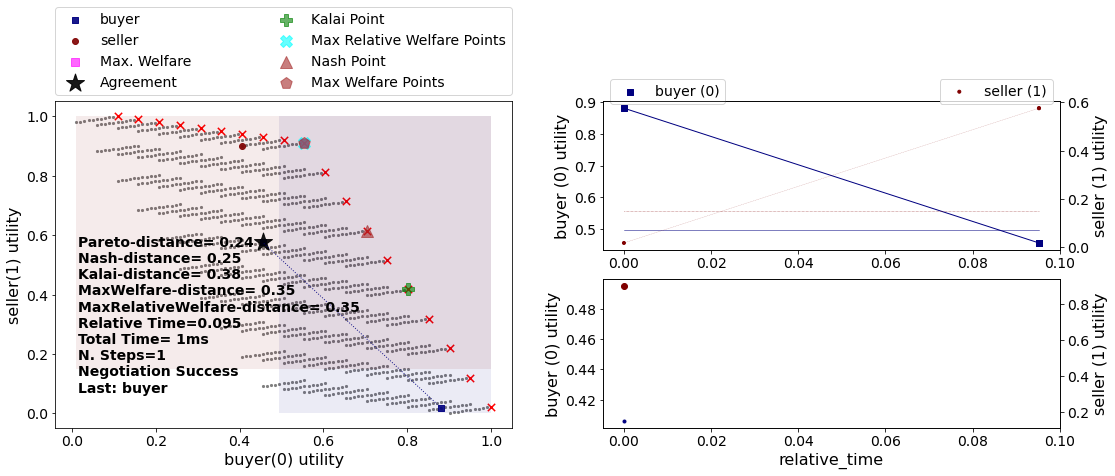

In [7]:
s = try_negotiator(RandomNegotiator)

What just happened? It seems that the buyer offered a single offer which was **immediately** accepted by the seller. We can check that explicitly by looking at the negotiation *trace* which stores all the offers exchanged (along with the agent that offered it): 

In [8]:
s.trace

[('buyer-c028fc32-61d2-42e7-aed2-98b4d7f140e5', (1, 4, 9)),
 ('seller-86743165-773b-4bd5-8ba7-16a0505b868f', (1, 1, 0)),
 ('buyer-c028fc32-61d2-42e7-aed2-98b4d7f140e5', (6, 11, 4))]

Why did this happen? To answer this question, let's try to run another negotiation but replacing only the buyer

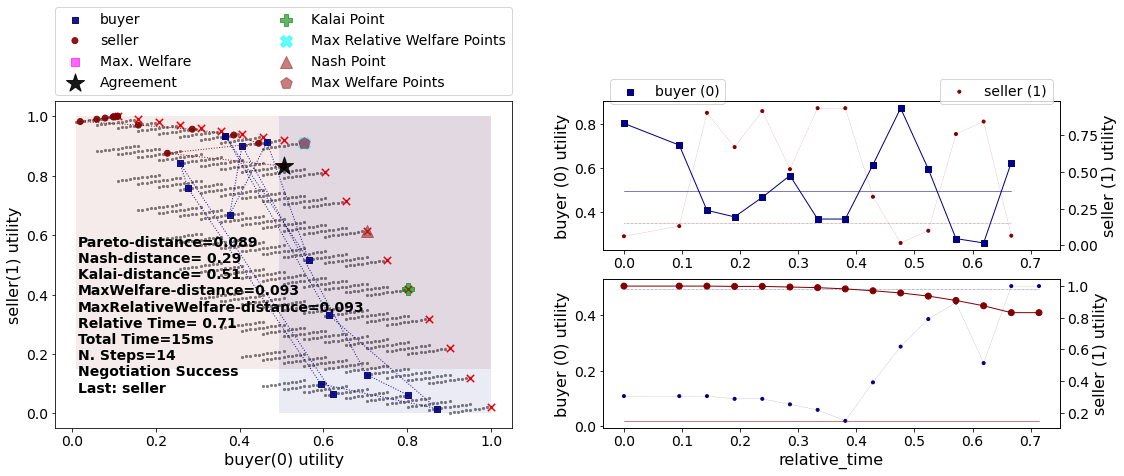

In [9]:
s2 = try_negotiator(RandomNegotiator, replace_seller=False)

The seller behaves as the time-based aspiration negotiator is expected to behave. It starts at its best outcome then it conceeds slowly. Our random buyer agent also seems to behave as expected, it offers outcomes all over the place. What happened in this case, is that the buyer accepted some offer from the seller. How did it decide to do so? We did not implement a way for our negotiator to make this decision.

The default acceptance strategy in NegMAS is to accept an outcome **if and only if it has a utility for the negotiator better or equal to whatever offer it would hace proposed at this negotiation state**.

So this is what happened, the buyer agent received some offer from the aspriation negotiator, it called our `propose` method to see what outcome would it have offered. Because our `propose` behaved randomly, it returned some outcome that has a utility less than or equal to the utility for the buyer of the seller's offer and that is why it accepted. 

It is clear that the default acceptance strategy in NegMAS does not make sense for our random negotiator (not that random offering makes sense in the first place :-) ). 

**Can you see why the first negotiation we attempted between our two random agents ended up at the first offer?**

Let's test your answer by checking if it explains what happens when we repeat the process and plot a histogram of the step (round) at which the negotiation ended.

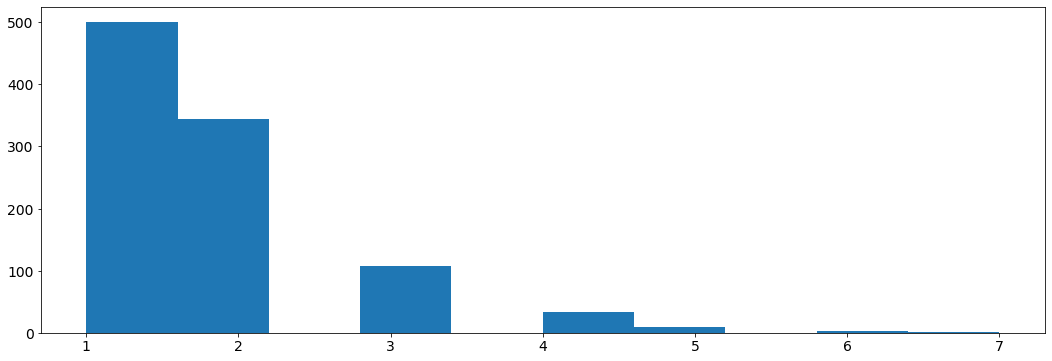

In [10]:
ended_at = [
    try_negotiator(RandomNegotiator, plot=False).state.step for _ in range(1000)
]
plt.hist(ended_at)
plt.show()

### Better acceptance strategy 

So how can we slightly improve our random negotiator. We can make it accept offers only if they are above some threshold. To do that we need to override the `respond` method which is used by the `SAOMechanism` to check if an outcome is acceptable for the negotiator. It has the following signature:

```python
def respond(self, state: SAOState, offer: Outcome, nid: str) -> ResponseType:
    ...
```

The `ResponseType` returned is an enum with different possible options. We are only interested in three of them:

- ACCEPT_OFFER: Accept
- REJECT_OFFER: Reject
- END_NEGOTIATION: End the negotiation immediately

Here is how we can add our acceptance strategy:

In [11]:
class BetterRandomNegotiator(RandomNegotiator):
    def respond(self, state, offer, source: str):
        if self.ufun(offer) > 0.9:
            return ResponseType.ACCEPT_OFFER
        return ResponseType.REJECT_OFFER

The only new thing for us here is that the negotiator can access it *own* utility function using `self.ufun`. Let's try to replace both agents with our slightly better random negotiator

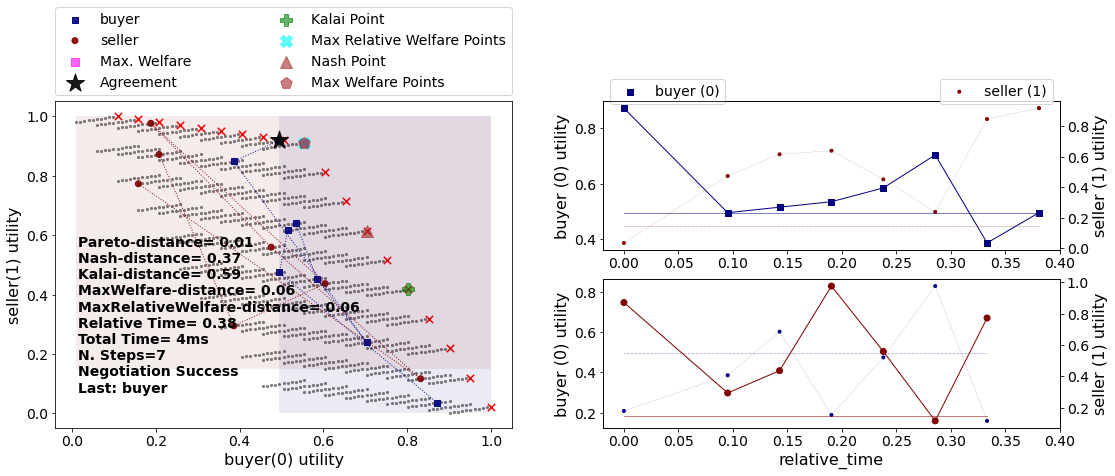

In [12]:
s3 = try_negotiator(BetterRandomNegotiator)

Now *both* agents are proposing randomly. How can we check that our *complicated* acceptance strategy is implemented correctly?

We can check that the agent that accepted the final offer (the seller in this case) had a utility above *0.8*. To do that we need to know a little bit about the `state` object which we receive in both `propose` and `respond` and can access at any time on the mechanism object using the `state` property. Here is the final state of the negotiation:

In [13]:
print(s3.state)

SAOState(
    running=False,
    waiting=False,
    started=True,
    step=8,
    time=0.004926916997646913,
    relative_time=0.42857142857142855,
    broken=False,
    timedout=False,
    agreement=(1, 10, 0),
    results=None,
    n_negotiators=2,
    has_error=False,
    error_details='',
    threads={},
    current_offer=(1, 10, 0),
    current_proposer='buyer-06dacdd3-0acb-477e-bb12-df88ab5c5052',
    current_proposer_agent=None,
    n_acceptances=2,
    new_offers=[('buyer-06dacdd3-0acb-477e-bb12-df88ab5c5052', (1, 10, 0))],
    new_offerer_agents=[None],
    last_negotiator='buyer'
)

Some of these state variables are specific to the `SAOMechanism` but others are common to all mechanisms (i.e. available in the `MechainsmState` class which is the parent of `SAOState`). Let's check some of these first:

Negotiation execution state:

- **started** Did the negotiation start?
- **running** Is the negotiation still running?
- **waiting** Is the negotiation waiting for some response from one of the negtiators?
- **has_errors** Does the negotiation have any exceptions?

Negotiation end state:

- **bronken** Did a negotiator end the negotiation (by returning `ResponseType.END_NEGOTIATION` from its `respond()` method).
- **timedout** The negotiation timed out without agreement.
- **agreement** The final agreement (or `None` if broken or timedout).

Timing state:

- **step** The current negotiation step (here it is *9* out of the *20* steps allowed)
- **time** The real time that passed since the negotiation stareted
- **relative_time** The fraction of teh negotiation that passed (here it is $(9+1)/(20+1=0.476...$).

There are also SAO specific state variables:

The most important for us are:

- **current_offer** which will be the same as the agreement as the negotiation has already ended.
- **current_proposer** The ID of the negotiator that proposed the `current_offer`.

Using this information, we can confirm the utility value of the agreement for the agent that accepted it as follows:


In [14]:
negotiator_ids = [_.id for _ in s3.negotiators]
acceptor = [i for i, _ in enumerate(negotiator_ids) if _ != s3.state.current_proposer][
    0
]
print(s3.negotiators[acceptor].ufun(s3.agreement))

0.9189723320158103

Seems OK. 

#### Parameterizing the Negotiator

One issue with our negotiator is that the acceptance threshold is hard-coded. We can add parameters to the negotiator while keeping the default parameters of all negotiators as follows:

In [15]:
class BetterRandomNegotiator(RandomNegotiator):
    def __init__(self, *args, acceptance_threshold=0.8, **kwargs):
        super().__init__(*args, **kwargs)
        self._th = acceptance_threshold

    def respond(self, state, offer, nid: str):
        if self.ufun(offer) > self._th:
            return ResponseType.ACCEPT_OFFER
        return ResponseType.REJECT_OFFER

### Smart Aspiration Negotiator

We now turn our attention to developing our smart aspiration negotiator: *concede as AspirationNegotiator, but offer the nearest outcome at a given utility level to the opponent's first offer*

To do that, we need to be able to find all outcomes above some utility threshold. To do that, we will use a class defined by NegMAS called `InverseUtilityFunction`. In general, negotiators in NegMAS should expect that the ufun may change at any time during the negotiation. Our negotiator will need to re-calculate the utility value associated with each outcome at every ufun change. It can do that in the `on_preferences_changed()` callback.

Moreover, we need some way to calcualate the current utility level we are willing to accept (and to offer around). Here we can use another component from NegMAS called `PolyAspiration` which is designed exactly for that. Let's see what the negotiator looks like and then explain it:

In [16]:
from random import choice
from negmas import PolyAspiration, PresortingInverseUtilityFunction


class SmartAspirationNegotiator(SAONegotiator):
    _inv = None  # The ufun invertor (finds outcomes in a utility range)
    _partner_first = None  # The best offer of the parter (assumed best for it)
    _min = None  # The minimum of my utility function
    _max = None  # The maximum of my utility function
    _best = None  # The best outcome for me

    def __init__(self, *args, **kwargs):
        # initialize the base SAONegoiator (MUST be done)
        super().__init__(*args, **kwargs)

        # Initialize the aspiration mixin to start at 1.0 and concede slowly
        self._asp = PolyAspiration(1.0, "boulware")

    def on_preferences_changed(self, changes):
        # create an initiaze an invertor for my ufun
        changes = [_ for _ in changes if _.type not in (PreferencesChangeType.Scale,)]
        if not changes:
            return
        self._inv = PresortingInverseUtilityFunction(self.ufun)
        self._inv.init()

        # find worst and best outcomes for me
        worest, self._best = self.ufun.extreme_outcomes()

        # and the correponding utility values
        self._min, self._max = self.ufun(worest), self.ufun(self._best)

        # MUST call parent to avoid being called again for no reason
        super().on_preferences_changed(changes)

    def respond(self, state, offer, source: str):
        # set the partner's first offer when I receive it
        if not self._partner_first:
            self._partner_first = offer

        # accept if the offer is not worse for me than what I would have offered
        return super().respond(state, offer, source)

    def propose(self, state):
        # calculate my current aspiration level (utility level at which I will offer and accept)
        a = (self._max - self._min) * self._asp.utility_at(
            state.relative_time
        ) + self._min

        # find some outcomes (all if the outcome space is  discrete) above the aspiration level
        outcomes = self._inv.some((a, self._max), False)

        # If there are no outcomes above the aspiration level, offer my best outcome
        if not outcomes:
            return self._best

        # else if I did not  recieve anything from the partner, offer any outcome above the aspiration level
        if not self._partner_first:
            return choice(outcomes)

        # otherwise, offer the outcome most similar to the partner's first offer (above the aspiration level)
        nearest, ndist = None, float("inf")
        for o in outcomes:
            d = sum((a - b) * (a - b) for a, b in zip(o, self._partner_first))
            if d < ndist:
                nearest, ndist = o, d
        return nearest

Let's look at this negotiator in details. We override four methods:
- **__init__()** to initialize the negotiator. This method should **alwyas** call `super().__init__()` to correctly initialize the negotiator. Moreover, we initialize the aspiration mixin to slowly concede from zero.
- **on_preferences_changed(changes)** to update the ufun inverter, my ufun's range and find out the best outcome. *You must call the parent's implementation using `super().on_preferences_changed()` to avoid unnecessary repeated calls to this method.
- **respond()** to implement our acceptance strategy. In this case the default NegMAS strategy is OK for us (called in the last line). We only need to save the partner's first offer here to use it in our offering strategy.
- **propose()** This is the core of the negotiator and implements its offering strategy. Let's look to it line by line:
  
  1. Calculate the current aspiration level which is the utility level above which we are going to offer
  ```python
     a = (self._max - self._min) * self.utility_at(state.relative_time) + self._min
  ```
  
  2. Find outcomes above my aspiration level. Note here that we use `some()` instead of `all()` to be compatible with continuous outcome spaces 
  ```python
    outcomes = self._inv.some((a, self._max), False) 
  ```
  
  3. We are now ready to generate our offer. We need to consider three cases:
    
    - No outcomes were found above the given threshold. Here we just offer our best offer
    ```python
      if not outcomes:
        return self._best
    ```
    - We do not know the partner's first offer (i.e. we are the first to offer in the negotiation). Here we just choose any outcome from the list `outcomes` (i.e. those above the aspiration level)
    ```python
      if not outcomes:
        return self._best
    ```
    
    - We have the partner's first offer. In this case, we find the distance between each of the outcomes we have (above the aspiration level) and the partner's first offer using Euclidean distance:
    ```python
      d = sum((a-b) * (a-b) for a, b in zip(o, self._partner_first))      
    ```
    
Can you see some of the hidden assumptions in this negotiator? 

While you are thinking about that, let's check our new negotiator:

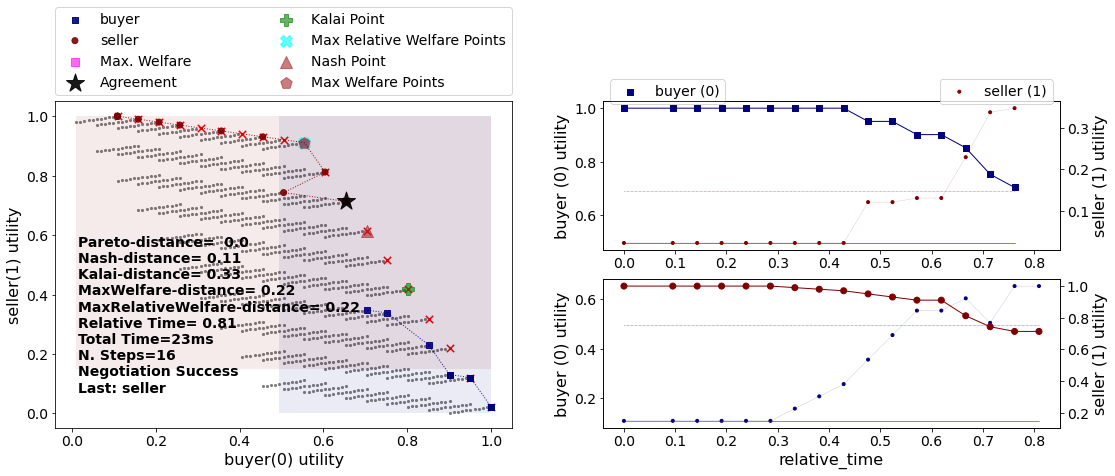

In [17]:
s = try_negotiator(SmartAspirationNegotiator)

As you can see, now the agreement is on the pareto front which means no money left on the table (i.e. it is impossible to increase the utility of one partner without decreasing the utility of the other).

That is a single negotiation though. Let's compare our new negotiator with `AspriationNegotiator` on multiple negotiations:

In [18]:
from collections import defaultdict

# find the pareto-frontier (it is the same for all negotiations)
frontier_utils, frontier_outcomes = s.pareto_frontier()
nash_utils, nash_outcome = s.nash_points()[0]
nash_welfare = sum(nash_utils)

# define the distance (Euclidean) to pareto frontier
def ed(a, b):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(a, b)))


def pareto_dist(a, frontier):
    # find the distance to the pareto-front (in outcome-space units)
    return min(ed(a, b) for b in frontier)


def nash_diff(a, nash_welfare):
    # find the difference in total welfare between the agreement and nash-agreement
    return nash_welfare - sum(_.ufun(a) for _ in s.negotiators)


# collect data about distance of the agreement to the pareto frontier
n, pdist, ndiff = 100, defaultdict(float), defaultdict(float)
for _ in range(n):
    for cls in (AspirationNegotiator, SmartAspirationNegotiator, RandomNegotiator):
        a = try_negotiator(cls, plot=False).state.agreement
        if not a:
            continue
        pdist[cls.__name__] += pareto_dist(a, frontier_outcomes) / n
        ndiff[cls.__name__] += nash_diff(a, nash_welfare) / n

print(f"{pdist=}\n{ndiff=}")

pdist=defaultdict(<class 'float'>, {'AspirationNegotiator': 4.262806533818797, 
'SmartAspirationNegotiator': 0.0, 'RandomNegotiator': 5.8138913384648125})
ndiff=defaultdict(<class 'float'>, {'AspirationNegotiator': 0.19860388212734353, 
'SmartAspirationNegotiator': -0.049309278753962425, 'RandomNegotiator': 0.25802508511720734})

It is clear that our negotiator achieved its goal. It reduces the distance to the pareto-front of the final agreement compared with vanilla `AspirationNegotiator` (`pdist`) to zero while reducing the difference in total welfare (utility sum) between the agreement and the best possible value (at the nash-point) by almost $70$%. Can you think of ways to further improve this design?


Back to our earlie question: *Can you see some of the hidden assumptions in this negotiator?* Here are some answers:

1. We implicitly assume that there is a meaningful distance measure defined over the outcome space. This is certainly not be the case if some of the outcomes are not cardinal. In our example, all outcomes are numeric but is it really meaningful to treat one day on the delivery issue as equal to one item as equal to one dollar? What can we do to avoid that? We can approximate distance over these issues by either matching (0) or mismatching (1). Moreover, we can consider the average matching score for all of the partner's offers so far instead of only the first one. Try to implement that. You will need to access the Negotiator-Mechanism-Interface (NMI) to get the negotiation issues using: `self.nmi.outcome_space`.
2. Our aspiration mixin assumes that the minimum value for aspiration is the reserved value instead of zero which does not match the way we use it in `propose()`. In our case, reserved values *were* zero so this had no effect. In a general negotiation though, the reserved value should be taken into account.

Now that you have some experience developing a negotiating agent, try to improve the design by handling these two issues.

You can check other negotiators in NegMAS for new ideas:


In [19]:
from negmas import all_negotiator_types

print(all_negotiator_types())

[<class 'negmas.sao.negotiators.controlled.ControlledSAONegotiator'>]